In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
from time import time

from sklearn.model_selection import learning_curve
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import (SVC, LinearSVC)
from sklearn import pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,roc_auc_score

In [4]:
def plot_learning_curve(estimator, title, X, y, scoring, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes, scoring=scoring,error_score=np.nan)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [5]:
# Utility function to report best scores
def report(results, scoring,n_top=3):
    if len(scoring)>1:
        for s in range(len(scoring)):
            for i in range(1, n_top + 1):
                candidates = np.flatnonzero(results['rank_test_'+scoring[s]] == i)
                for candidate in candidates:
                    print("Model with rank: {0}".format(i))
                    print("Mean validation {0:}: {1:.3f} (std: {2:.3f})".format(
                          scoring[s],
                          results['mean_test_'+scoring[s]][candidate],
                          results['std_test_'+scoring[s]][candidate]))
                    print("Parameters: {0}".format(results['params'][candidate]))
                    print("")
                    
    else:
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation {0:}: {1:.3f} (std: {2:.3f})".format(
                      scoring[0],
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

In [6]:
le = preprocessing.LabelEncoder()

In [7]:
#import csv dataset from current working directory
#check current working directory: os.getcwd()
raw_dat = pd.DataFrame.from_csv('bank.csv', index_col=None)

In [8]:
df = raw_dat
col_category = list(raw_dat.columns[raw_dat.dtypes == 'object'].values)
col_numeric = list(raw_dat.columns[raw_dat.dtypes == 'int64'].values)

#encode labels for categorical variables
def encoder(df, column):
    df[column + '_label'] = le.fit_transform(df[column])
    return dict(zip(list(le.classes_),range(len(list(le.classes_)))))

encoder_schema = dict(zip(col_category,[encoder(df,col) for col in col_category]))


#exclude orginal categorical columns
df_encoded = df.iloc[:,(df.dtypes != 'object').values]

In [9]:
#feature scaling for numeric columns
def feature_scaling(df, column):
    scaler = StandardScaler()
    scaler.fit(df[column].astype(float).values.reshape(-1, 1))
    df[column + '_scaling'] = pd.Series([i[0] for i in scaler.transform(df[column].astype(float).values.reshape(-1, 1))],\
                                        index=df_encoded.index)
    return (column + '_scaling')
df_encoded = df_encoded.copy()    
col_scaling = [feature_scaling(df_encoded,c) for c in col_numeric]

In [10]:
#include all pre-processed columns
all_columns = [c for c in df_encoded.columns if c.endswith('_label')]+col_scaling
feature_columns = all_columns[:all_columns.index('y_label')]+col_scaling
df_preprocessed = df_encoded[all_columns]
df_preprocessed

,job_label,marital_label,education_label,default_label,housing_label,loan_label,contact_label,month_label,poutcome_label,y_label,age_scaling,balance_scaling,day_scaling,duration_scaling,campaign_scaling,pdays_scaling,previous_scaling
0,10,1,0,0,0,0,0,10,3,0,-1.056270,0.121072,0.374052,-0.711861,-0.576829,-0.407218,-0.320413
1,7,1,1,0,1,1,0,8,0,0,-0.772583,1.118644,-0.596026,-0.169194,-0.576829,2.989044,2.041734
2,4,2,2,0,1,0,0,0,0,0,-0.583458,-0.024144,0.010273,-0.303898,-0.576829,2.899143,0.270124
3,4,1,2,0,1,1,2,6,3,0,-1.056270,0.017726,-1.566105,-0.250017,0.387967,-0.407218,-0.320413
4,1,1,1,0,1,0,2,8,3,0,1.686036,-0.472753,-1.323585,-0.146102,-0.576829,-0.407218,-0.320413
5,4,2,2,0,0,0,0,3,0,0,-0.583458,-0.224523,0.859091,-0.473241,-0.255231,1.360836,1.451197
6,6,1,2,0,1,0,0,8,1,0,-0.488896,-0.370736,-0.232247,0.296499,-0.576829,2.899143,0.860660
7,9,1,1,0,1,0,0,8,3,0,-0.205209,-0.423904,-1.202326,-0.434754,-0.255231,-0.407218,-0.320413
8,2,1,2,0,1,0,2,8,3,0,-0.016085,-0.399314,-0.232247,-0.796532,-0.255231,-0.407218,-0.320413
9,7,1,0,0,1,1,0,0,0,0,0.173040,-0.501996,0.131532,0.188735,-0.576829,1.071155,0.860660


In [16]:
#check if any null value in dataset
df_preprocessed.isnull().values.any()

False

In [17]:
#check the imbalance in target class
df_preprocessed.groupby(['y_label']).count().iloc[:,0]

y_label
0    4000
1     521
Name: job_label, dtype: int64

In [11]:
#split the dataset into trainset and testset
RANDOM_SEED = 5

X = df_preprocessed
y = df_preprocessed['y_label']
trainset,testset=train_test_split(X, test_size=0.25, stratify=y, random_state=RANDOM_SEED)

In [14]:
#dump splited dataset  
trainset.to_csv('trainset_p1.csv')
testset.to_csv('testset_p1.csv')

In [11]:
#Load in data
trainset = pd.read_csv('trainset_p1.csv').iloc[:,1:]
testset= pd.read_csv('testset_p1.csv').iloc[:,1:]

In [12]:
#resampling
sm = SMOTE(kind='regular')
X_train_smote, y_train_smote = sm.fit_sample(trainset[feature_columns],trainset['y_label'])

In [21]:
#dump splited dataset  
pd.DataFrame(X_train_smote).to_csv('X_train_smote_p1.csv')
pd.DataFrame(y_train_smote).to_csv('y_train_smote_p1.csv')

In [12]:
#Load in data
X_train_smote = pd.read_csv('X_train_smote_p1.csv').iloc[:,1:]
y_train_smote= pd.read_csv('y_train_smote_p1.csv').iloc[:,1:]

In [11]:
#chekc the target class distribution after SMOTE processing
y_train_smote.reset_index().groupby(['0']).count().iloc[:,0]

0
0    2999
1    2999
Name: index, dtype: int64

In [13]:
#knn
n_iter_search = 20

parameters = {'weights':['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
              'p': np.array(range(1,4))}

clf_knn3 = clf_knn3_smote = RandomizedSearchCV(neighbors.KNeighborsClassifier(n_neighbors=3), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

clf_knn6 = clf_knn6_smote = RandomizedSearchCV(neighbors.KNeighborsClassifier(n_neighbors=6), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

In [36]:
#knn3 on imbalanced data
start = time()
clf_knn3.fit(trainset[feature_columns],trainset['y_label'])
print("clf_knn3 took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_knn3.cv_results_,scoring=['roc_auc','f1'])

clf_knn3 took 255.46 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.713 (std: 0.032)
Parameters: {'algorithm': 'auto', 'p': 3, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.713 (std: 0.032)
Parameters: {'algorithm': 'kd_tree', 'p': 3, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.713 (std: 0.032)
Parameters: {'algorithm': 'brute', 'p': 3, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.713 (std: 0.032)
Parameters: {'algorithm': 'ball_tree', 'p': 3, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.294 (std: 0.066)
Parameters: {'algorithm': 'brute', 'p': 2, 'weights': 'uniform'}

Model with rank: 1
Mean validation f1: 0.294 (std: 0.066)
Parameters: {'algorithm': 'kd_tree', 'p': 2, 'weights': 'uniform'}

Model with rank: 1
Mean validation f1: 0.294 (std: 0.066)
Parameters: {'algorithm': 'ball_tree', 'p': 2, 'weights': 'uniform'}

Model with rank: 1
Mean valida

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')


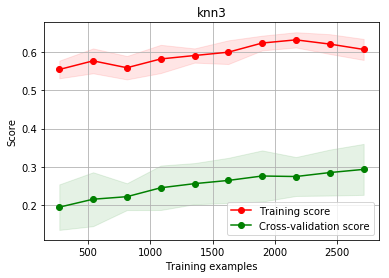

In [37]:
clf_knn3_optim = clf_knn3.best_estimator_
print(clf_knn3_optim)
%matplotlib inline

plot_learning_curve(clf_knn3_optim, "knn3",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_knn3_optim.sav'
pickle.dump(clf_knn3_optim, open(filename, 'wb'))

In [61]:
#create a performacne dataframe and record the performance on both trainset and testset
clf_knn3_optim = pickle.load(open(r'.\Problem_1_Model\clf_knn3_optim.sav', 'rb'))
clf_performance = pd.DataFrame(columns=['classifier','trainset_roc_auc','testset_roc_auc','trainset_f1','testset_f1'])

start = time()
clf_knn3_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of knn3 is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_knn3_optim.predict(trainset[feature_columns])

y_pred_test = clf_knn3_optim.predict(testset[feature_columns])

knn3_perf={'classifier':'knn3',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[0]=knn3_perf

The training time of knn3 is 0.003s


In [41]:
#knn6 on imbalanced data
start = time()
clf_knn6.fit(trainset[feature_columns],trainset['y_label'])
print("clf_knn6 took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_knn6.cv_results_,scoring=['roc_auc','f1'])

clf_knn6 took 187.83 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.776 (std: 0.039)
Parameters: {'algorithm': 'kd_tree', 'p': 2, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.776 (std: 0.039)
Parameters: {'algorithm': 'auto', 'p': 2, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.776 (std: 0.039)
Parameters: {'algorithm': 'brute', 'p': 2, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.264 (std: 0.026)
Parameters: {'algorithm': 'kd_tree', 'p': 3, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.264 (std: 0.026)
Parameters: {'algorithm': 'auto', 'p': 3, 'weights': 'distance'}

Model with rank: 3
Mean validation f1: 0.246 (std: 0.029)
Parameters: {'algorithm': 'kd_tree', 'p': 2, 'weights': 'distance'}

Model with rank: 3
Mean validation f1: 0.246 (std: 0.029)
Parameters: {'algorithm': 'auto', 'p': 2, 'weights': 'distance'}

Model with rank: 3
Mean validation f1: 0

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=3,
           weights='distance')


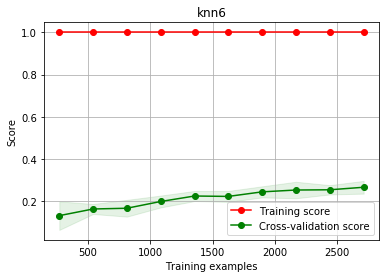

In [42]:
clf_knn6_optim = clf_knn6.best_estimator_
print(clf_knn6_optim)
%matplotlib inline

plot_learning_curve(clf_knn6_optim, "knn6",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = 'clf_knn6_optim.sav'
pickle.dump(clf_knn6_optim, open(filename, 'wb'))

In [62]:
clf_knn6_optim = pickle.load(open(r'.\Problem_1_Model\clf_knn6_optim.sav','rb'))

start = time()
clf_knn6_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of knn6 is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_knn6_optim.predict(trainset[feature_columns])

y_pred_test = clf_knn6_optim.predict(testset[feature_columns])

knn6_perf={'classifier':'knn6',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=knn6_perf

The training time of knn6 is 0.006s


In [48]:
#knn3 on SMOTE data
start = time()
clf_knn3_smote.fit(X_train_smote, np.ravel(y_train_smote))
print("KNN with K=3 on SMOTE data took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_knn3_smote.cv_results_,scoring=['roc_auc','f1'])

KNN with K=3 on SMOTE data took 379.87 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.974 (std: 0.005)
Parameters: {'algorithm': 'brute', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.974 (std: 0.005)
Parameters: {'algorithm': 'kd_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.974 (std: 0.005)
Parameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.974 (std: 0.005)
Parameters: {'algorithm': 'ball_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.950 (std: 0.006)
Parameters: {'algorithm': 'brute', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.950 (std: 0.006)
Parameters: {'algorithm': 'kd_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.950 (std: 0.006)
Parameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model with ran

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=1,
           weights='distance')


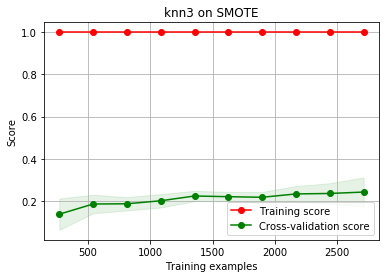

In [49]:
#clf_knn3_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_knn3_smote_optim.sav', 'rb'))
clf_knn3_smote_optim = clf_knn3_smote.best_estimator_
print(clf_knn3_smote_optim)
%matplotlib inline

plot_learning_curve(clf_knn3_smote_optim, "knn3 on SMOTE",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_knn3_smote_optim.sav'
pickle.dump(clf_knn3_smote_optim, open(filename, 'wb'))

In [16]:
#clf_knn3_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_knn3_smote_optim.sav','rb'))

start = time()
clf_knn3_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of knn3 after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_knn3_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_knn3_smote_optim.predict(testset[feature_columns])

knn3_smote_perf={'classifier':'knn3_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=knn3_smote_perf

The training time of knn3 after SMOTE is 0.003s


In [54]:
#knn6 on SMOTE data
start = time()
clf_knn6_smote.fit(X_train_smote, np.ravel(y_train_smote))
print("clf_knn6_smote took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_knn6_smote.cv_results_,scoring=['roc_auc','f1'])

clf_knn6_smote took 736.74 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.985 (std: 0.006)
Parameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.985 (std: 0.006)
Parameters: {'algorithm': 'ball_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.985 (std: 0.006)
Parameters: {'algorithm': 'kd_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation roc_auc: 0.985 (std: 0.006)
Parameters: {'algorithm': 'brute', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.945 (std: 0.003)
Parameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.945 (std: 0.003)
Parameters: {'algorithm': 'ball_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mean validation f1: 0.945 (std: 0.003)
Parameters: {'algorithm': 'kd_tree', 'p': 1, 'weights': 'distance'}

Model with rank: 1
Mea

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=1,
           weights='distance')


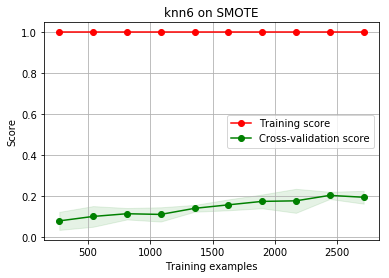

In [55]:
#clf_knn6_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_knn6_smote_optim.sav', 'rb'))
clf_knn6_smote_optim = clf_knn6_smote.best_estimator_
print(clf_knn6_smote_optim)
%matplotlib inline

plot_learning_curve(clf_knn6_smote_optim, "knn6 on SMOTE",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_knn6_smote_optim.sav'
pickle.dump(clf_knn6_smote_optim, open(filename, 'wb'))

In [20]:
clf_knn6_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_knn6_smote_optim.sav','rb'))

start = time()
clf_knn6_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of knn6 after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_knn6_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_knn6_smote_optim.predict(testset[feature_columns])

knn6_smote_perf={'classifier':'knn6_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=knn6_smote_perf

The training time of knn6 after SMOTE is 0.006s


In [59]:
#decision tree
parameters = {'splitter':['best', 'random'], 'max_depth': [None, 5, 7, 9], 
              'min_samples_split': np.linspace(2,10,num=5).astype(int),
              'max_features': ['auto','log2',None]}

clf_dt = clf_dt_smote = RandomizedSearchCV(DecisionTreeClassifier(criterion='entropy'), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')


parameters_weighted = {'splitter':['best', 'random'], 'max_depth': [None, 5, 7, 9], 
              'min_samples_split': np.linspace(2,10,num=5).astype(int),
              'max_features': ['auto','log2',None], 'class_weight':[{0:1,1:5},{0:1,1:10},{0:1,1:50},{0:1,1:100},{0:1,1:500}]}

clf_dt_weighted = RandomizedSearchCV(DecisionTreeClassifier(criterion='entropy'), param_distributions=parameters_weighted,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

In [60]:
start = time()
clf_dt.fit(trainset[feature_columns],trainset['y_label'])
print("Decision tree took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_dt.cv_results_,scoring=['roc_auc','f1'])

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Decision tree took 1.72 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.844 (std: 0.013)
Parameters: {'min_samples_split': 6, 'max_depth': 5, 'max_features': None, 'splitter': 'best'}

Model with rank: 2
Mean validation roc_auc: 0.843 (std: 0.014)
Parameters: {'min_samples_split': 2, 'max_depth': 5, 'max_features': None, 'splitter': 'best'}

Model with rank: 3
Mean validation roc_auc: 0.820 (std: 0.029)
Parameters: {'min_samples_split': 10, 'max_depth': 5, 'max_features': 'log2', 'splitter': 'best'}

Model with rank: 1
Mean validation f1: 0.424 (std: 0.037)
Parameters: {'min_samples_split': 4, 'max_depth': 7, 'max_features': None, 'splitter': 'best'}

Model with rank: 2
Mean validation f1: 0.420 (std: 0.024)
Parameters: {'min_samples_split': 6, 'max_depth': 9, 'max_features': None, 'splitter': 'random'}

Model with rank: 3
Mean validation f1: 0.401 (std: 0.076)
Parameters: {'min_samples_split': 4, 'max_depth': None, 'max_features': 'auto', 's

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


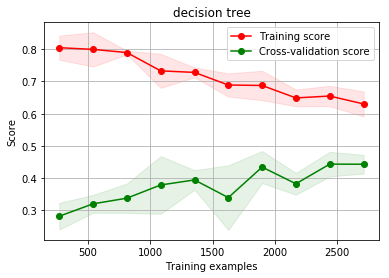

In [61]:
#clf_dt_optim = pickle.load(open(r'.\Problem_1_Model\clf_dt_optim.sav', 'rb'))
clf_dt_optim = clf_dt.best_estimator_
print(clf_dt_optim)

%matplotlib inline

plot_learning_curve(clf_dt_optim , "decision tree",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_dt_optim.sav'
pickle.dump(clf_dt_optim, open(filename, 'wb'))

In [65]:
#clf_dt_optim = pickle.load(open(r'.\Problem_1_Model\clf_dt_optim.sav','rb'))

start = time()
clf_dt_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of decision tree is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_dt_optim.predict(trainset[feature_columns])

y_pred_test = clf_dt_optim.predict(testset[feature_columns])


dt_perf={'classifier':'dt',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }
clf_performance.loc[(clf_performance.index.max()+1)]=dt_perf

The training time of decision tree is 0.015s


In [65]:
#decision tree on SMOTE data
start = time()
clf_dt_smote.fit(X_train_smote, y_train_smote)
print("clf_dt_smote took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_dt_smote.cv_results_,scoring=['roc_auc','f1'])

clf_dt_smote took 2.88 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.938 (std: 0.028)
Parameters: {'min_samples_split': 8, 'max_depth': 9, 'max_features': None, 'splitter': 'best'}

Model with rank: 2
Mean validation roc_auc: 0.931 (std: 0.025)
Parameters: {'min_samples_split': 10, 'max_depth': 9, 'max_features': 'log2', 'splitter': 'best'}

Model with rank: 3
Mean validation roc_auc: 0.923 (std: 0.038)
Parameters: {'min_samples_split': 10, 'max_depth': None, 'max_features': None, 'splitter': 'best'}

Model with rank: 1
Mean validation f1: 0.901 (std: 0.029)
Parameters: {'min_samples_split': 2, 'max_depth': None, 'max_features': 'log2', 'splitter': 'random'}

Model with rank: 2
Mean validation f1: 0.900 (std: 0.041)
Parameters: {'min_samples_split': 2, 'max_depth': None, 'max_features': None, 'splitter': 'best'}

Model with rank: 3
Mean validation f1: 0.891 (std: 0.050)
Parameters: {'min_samples_split': 10, 'max_depth': None, 'max_features'

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')


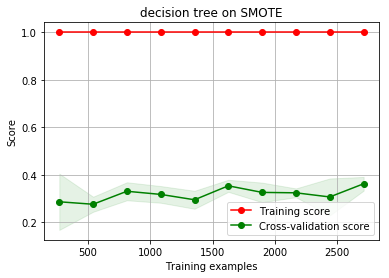

In [66]:
#clf_dt_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_dt_smote_optim.sav', 'rb'))
clf_dt_smote_optim = clf_dt_smote.best_estimator_
print(clf_dt_smote_optim)

%matplotlib inline

plot_learning_curve(clf_dt_smote_optim , "decision tree on SMOTE",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_dt_smote_optim.sav'
pickle.dump(clf_dt_smote_optim, open(filename, 'wb'))

In [66]:
clf_dt_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_dt_smote_optim.sav','rb'))

start = time()
clf_dt_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of decision tree after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_dt_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_dt_smote_optim.predict(testset[feature_columns])

dt_smote_perf={'classifier':'dt_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=dt_smote_perf

The training time of decision tree after SMOTE is 0.006s


In [70]:
#decision tree with class weight
start = time()
clf_dt_weighted.fit(trainset[feature_columns],trainset['y_label'])
print("Decision tree took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_dt_weighted.cv_results_,scoring=['roc_auc','f1'])

Decision tree took 1.83 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.840 (std: 0.014)
Parameters: {'min_samples_split': 10, 'max_depth': 5, 'class_weight': {0: 1, 1: 100}, 'max_features': None, 'splitter': 'best'}

Model with rank: 2
Mean validation roc_auc: 0.792 (std: 0.022)
Parameters: {'min_samples_split': 4, 'max_depth': 7, 'class_weight': {0: 1, 1: 50}, 'max_features': None, 'splitter': 'random'}

Model with rank: 3
Mean validation roc_auc: 0.786 (std: 0.051)
Parameters: {'min_samples_split': 2, 'max_depth': 7, 'class_weight': {0: 1, 1: 10}, 'max_features': None, 'splitter': 'random'}

Model with rank: 1
Mean validation f1: 0.452 (std: 0.027)
Parameters: {'min_samples_split': 2, 'max_depth': 9, 'class_weight': {0: 1, 1: 5}, 'max_features': None, 'splitter': 'best'}

Model with rank: 2
Mean validation f1: 0.404 (std: 0.012)
Parameters: {'min_samples_split': 8, 'max_depth': None, 'class_weight': {0: 1, 1: 10}, 'max_features': None, 'sp

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, criterion='entropy',
            max_depth=9, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


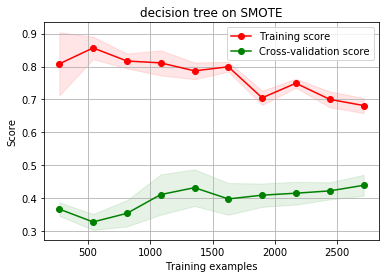

In [71]:
#clf_dt_weighted_optim = pickle.load(open(r'.\Problem_1_Model\clf_dt_weighted_optim.sav', 'rb'))
clf_dt_weighted_optim = clf_dt_weighted.best_estimator_
print(clf_dt_weighted_optim)

%matplotlib inline

plot_learning_curve(clf_dt_weighted_optim , "decision tree with class weight",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_dt_weighted_optim.sav'
pickle.dump(clf_dt_weighted_optim, open(filename, 'wb'))


In [68]:
clf_dt_weighted_optim = pickle.load(open(r'.\Problem_1_Model\clf_dt_weighted_optim.sav','rb'))

start = time()
clf_dt_weighted_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of decision tree with class weight is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_dt_weighted_optim.predict(trainset[feature_columns])

y_pred_test = clf_dt_weighted_optim.predict(testset[feature_columns])

dt_weighted_perf={'classifier':'dt_weighted',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=dt_weighted_perf

The training time of decision tree with class weight is 0.019s


In [12]:
#svm
parameters_lin = {'loss':['hinge','squared_hinge'], 'C':list(10. ** np.arange(1, 4))}
parameters_rbf = {'C':list(10. ** np.arange(-4, 6)), 'shrinking': [True, False], 'gamma':np.linspace(0.000001,0.0001,num=20)}
parameters_rbf_weighted = {'C':list(10. ** np.arange(-4, 6)), 'shrinking': [True, False], \
                           'gamma':np.linspace(0.000001,0.0001,num=20),\
                           'class_weight':[{0:1,1:5},{0:1,1:10},{0:1,1:50},{0:1,1:100},{0:1,1:500}]}



#feature_map_fourier = RBFSampler(gamma=0.000006)
#feature_map_nystroem = Nystroem(gamma=0.000006)

clf_svclin = clf_svclin_smote = RandomizedSearchCV(LinearSVC(max_iter=50000000), param_distributions=parameters_lin,
                                   n_iter=5, scoring=['roc_auc','f1'], cv=3,refit='f1')

clf_svcrbf = clf_svcrbf_smote = RandomizedSearchCV(SVC(kernel='rbf',max_iter=2000000), param_distributions=parameters_rbf,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

clf_svcrbf_weighted = RandomizedSearchCV(SVC(kernel='rbf',max_iter=2000000), param_distributions=parameters_rbf_weighted,

                                         n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

In [ ]:
#Linear kernel
start = time()
#X = feature_map_fourier.fit_transform(trainset[feature_columns])
clf_svclin.fit(trainset[feature_columns],trainset['y_label'])
print("Linear kernel svc took %.2f seconds for %d candidates parameter settings." % ((time() - start), 5))
report(clf_svclin.cv_results_,scoring=['roc_auc','f1'])

In [ ]:
#clf_svclin_optim = pickle.load(open(r'.\Problem_1_Model\clf_svclin_optim.sav','rb'))
clf_svclin_optim = clf_svclin.best_estimator_
print(clf_svclin_optim)

%matplotlib inline

plot_learning_curve(clf_svclin_optim , "Linear kernel SVC",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_svclin_optim.sav'
pickle.dump(clf_svclin_optim, open(filename, 'wb'))

In [15]:
clf_svclin_optim = pickle.load(open(r'.\Problem_1_Model\clf_svclin_optim.sav','rb'))
start = time()
clf_svclin_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of SVC Linear kernel is %.3fs'%(round(time()-start,3)))

The training time of SVC Linear kernel is 2107.603s


C:\Anaconda\envs\py35\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
start = time()
clf_svclin_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of SVC Linear kernel is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_svclin_optim.predict(trainset[feature_columns])

y_pred_test = clf_svclin_optim.predict(testset[feature_columns])

svclin_perf={'classifier':'svclin',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=svclin_perf

In [93]:
#rbf kernel
start = time()
#X = feature_map_fourier.fit_transform(trainset.iloc[:,:-1])
clf_svcrbf.fit(trainset[feature_columns],trainset['y_label'])
print("RBF kernel svc took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_svcrbf.cv_results_,scoring=['roc_auc','f1'])

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


RBF kernel svc took 77.66 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.861 (std: 0.008)
Parameters: {'gamma': 3.226315789473684e-05, 'shrinking': False, 'C': 10000.0}

Model with rank: 2
Mean validation roc_auc: 0.860 (std: 0.015)
Parameters: {'gamma': 1e-06, 'shrinking': True, 'C': 10000.0}

Model with rank: 3
Mean validation roc_auc: 0.860 (std: 0.008)
Parameters: {'gamma': 4.789473684210526e-05, 'shrinking': True, 'C': 10000.0}

Model with rank: 1
Mean validation f1: 0.172 (std: 0.051)
Parameters: {'gamma': 5.3105263157894734e-05, 'shrinking': True, 'C': 100000.0}

Model with rank: 2
Mean validation f1: 0.122 (std: 0.042)
Parameters: {'gamma': 3.7473684210526315e-05, 'shrinking': False, 'C': 100000.0}

Model with rank: 3
Mean validation f1: 0.054 (std: 0.010)
Parameters: {'gamma': 6.873684210526315e-05, 'shrinking': False, 'C': 10000.0}



SVC(C=100000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=5.3105263157894734e-05,
  kernel='rbf', max_iter=2000000, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


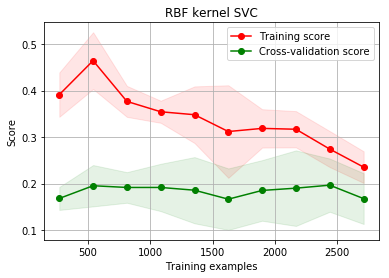

In [94]:
clf_svcrbf_optim = clf_svcrbf.best_estimator_
print(clf_svcrbf_optim)

%matplotlib inline

plot_learning_curve(clf_svcrbf_optim , "RBF kernel SVC",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_svcrbf_optim.sav'
pickle.dump(clf_svcrbf_optim, open(filename, 'wb'))

In [95]:
#clf_svcrbf_optim = pickle.load(open(r'.\Problem_1_Model\clf_svcrbf_optim.sav','rb'))

start = time()
clf_svcrbf_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of SVC RBF kernel is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_svcrbf_optim.predict(trainset[feature_columns])

y_pred_test = clf_svcrbf_optim.predict(testset[feature_columns])

svcrbf_perf={'classifier':'svcrbf',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=svcrbf_perf

The training time of SVC RBF kernel is 2.139s


In [96]:
#rbf kernel on SMOTE
start = time()
clf_svcrbf_smote.fit(X_train_smote, np.ravel(y_train_smote))
print("RBF kernel svc on SMOTE took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_svcrbf_smote.cv_results_,scoring=['roc_auc','f1'])

RBF kernel svc on SMOTE took 322.18 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.901 (std: 0.008)
Parameters: {'gamma': 8.436842105263158e-05, 'shrinking': False, 'C': 10000.0}

Model with rank: 2
Mean validation roc_auc: 0.898 (std: 0.007)
Parameters: {'gamma': 6.873684210526315e-05, 'shrinking': True, 'C': 10000.0}

Model with rank: 3
Mean validation roc_auc: 0.888 (std: 0.006)
Parameters: {'gamma': 8.436842105263158e-05, 'shrinking': False, 'C': 1000.0}

Model with rank: 1
Mean validation f1: 0.830 (std: 0.009)
Parameters: {'gamma': 8.436842105263158e-05, 'shrinking': False, 'C': 10000.0}

Model with rank: 2
Mean validation f1: 0.828 (std: 0.010)
Parameters: {'gamma': 6.873684210526315e-05, 'shrinking': True, 'C': 10000.0}

Model with rank: 3
Mean validation f1: 0.822 (std: 0.007)
Parameters: {'gamma': 7.394736842105263e-05, 'shrinking': False, 'C': 1000.0}



SVC(C=10000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=8.436842105263158e-05,
  kernel='rbf', max_iter=2000000, probability=False, random_state=None,
  shrinking=False, tol=0.001, verbose=False)


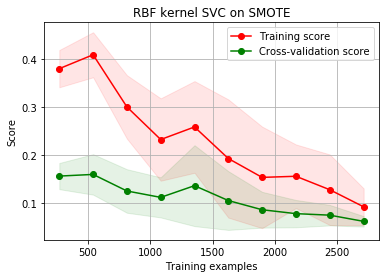

In [97]:
#clf_svcrbf_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_svcrbf_smote_optim.sav', 'rb'))
clf_svcrbf_smote_optim = clf_svcrbf_smote.best_estimator_
print(clf_svcrbf_smote_optim)

%matplotlib inline

plot_learning_curve(clf_svcrbf_smote_optim , "RBF kernel SVC on SMOTE",
                    trainset[feature_columns], trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_svcrbf_smote_optim.sav'
pickle.dump(clf_svcrbf_smote_optim, open(filename, 'wb'))

In [ ]:
#clf_svcrbf_smote_optim = pickle.load(open('clf_svcrbf_smote_optim.sav','rb'))

start = time()
clf_svcrbf_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of SVC RBF kernel after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_svcrbf_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_svcrbf_smote_optim.predict(testset[feature_columns])

svcrbf_smote_perf={'classifier':'svcrbf_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=svcrbf_smote_perf

In [16]:
clf_svcrbf_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_svcrbf_smote_optim.sav','rb'))
start = time()
clf_svcrbf_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of SVC RBF kernel after SMOTE is %.3fs'%(round(time()-start,3)))

The training time of SVC RBF kernel after SMOTE is 12.989s


In [99]:
#rbf kernel with class weight
start = time()
clf_svcrbf_weighted.fit(trainset[feature_columns],trainset['y_label'])
print("RBF kernel svc took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_svcrbf_weighted.cv_results_,scoring=['roc_auc','f1'])

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

RBF kernel svc took 148.30 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.871 (std: 0.017)
Parameters: {'gamma': 5.831578947368421e-05, 'shrinking': True, 'class_weight': {0: 1, 1: 10}, 'C': 10000.0}

Model with rank: 2
Mean validation roc_auc: 0.868 (std: 0.018)
Parameters: {'gamma': 3.226315789473684e-05, 'shrinking': False, 'class_weight': {0: 1, 1: 5}, 'C': 10000.0}

Model with rank: 3
Mean validation roc_auc: 0.866 (std: 0.018)
Parameters: {'gamma': 3.7473684210526315e-05, 'shrinking': False, 'class_weight': {0: 1, 1: 10}, 'C': 1000.0}

Model with rank: 1
Mean validation f1: 0.508 (std: 0.023)
Parameters: {'gamma': 3.226315789473684e-05, 'shrinking': False, 'class_weight': {0: 1, 1: 5}, 'C': 10000.0}

Model with rank: 2
Mean validation f1: 0.482 (std: 0.021)
Parameters: {'gamma': 1.1421052631578948e-05, 'shrinking': True, 'class_weight': {0: 1, 1: 5}, 'C': 100.0}

Model with rank: 3
Mean validation f1: 0.455 (std: 0.017)
Parameters: {'g

SVC(C=10000.0, cache_size=200, class_weight={0: 1, 1: 5}, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=3.226315789473684e-05,
  kernel='rbf', max_iter=2000000, probability=False, random_state=None,
  shrinking=False, tol=0.001, verbose=False)


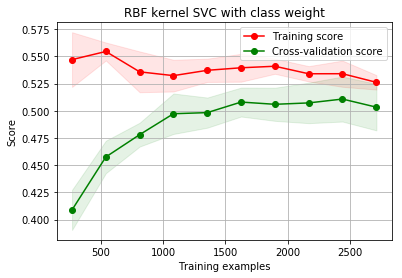

In [100]:
clf_svcrbf_weighted_optim = clf_svcrbf_weighted.best_estimator_
print(clf_svcrbf_weighted_optim)

%matplotlib inline

plot_learning_curve(clf_svcrbf_weighted_optim , "RBF kernel SVC with class weight",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_svcrbf_weighted_optim.sav'
pickle.dump(clf_svcrbf_weighted_optim, open(filename, 'wb'))

In [101]:
#clf_svcrbf_weighted_optim = pickle.load(open(r'.\Problem_1_Model\clf_svcrbf_weighted_optim.sav','rb'))

start = time()
clf_svcrbf_weighted_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of SVC RBF kernel with class weight is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_svcrbf_weighted_optim.predict(trainset[feature_columns])

y_pred_test = clf_svcrbf_weighted_optim.predict(testset[feature_columns])

svcrbf_weighted_perf={'classifier':'svcrbf_weighted',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=svcrbf_weighted_perf

The training time of SVC RBF kernel with class weight is 1.361s


In [149]:
#boosting
n_iter_search = 20
parameters_Ada = {'n_estimators':np.linspace(25,250,num=10).astype(int), 
                  'learning_rate': np.linspace(0.1,1,num=19), 'algorithm':['SAMME','SAMME.R']}

parameters_gradient = {'loss':['deviance','exponential'], 'learning_rate': np.linspace(0.1,1,num=19),
                       'n_estimators':np.linspace(25,250,num=10).astype(int),'subsample':np.linspace(0.1,1,num=10),
                       'criterion':['friedman_mse','mse','mae'],'min_samples_split': np.linspace(2,10,num=5).astype(int),
                       'max_depth': [None, 5, 7, 9], 'max_features': ['auto','log2',None]}



clf_adaboosting = clf_adaboosting_smote = RandomizedSearchCV(AdaBoostClassifier(), param_distributions=parameters_Ada,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

clf_gradientboosting = clf_gradientboosting_smote = \
                    RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=parameters_gradient,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

In [150]:
#Adaboost
start = time()
clf_adaboosting.fit(trainset[feature_columns],trainset['y_label'])
print("Adaboosting classifier took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_adaboosting.cv_results_,scoring=['roc_auc','f1'])

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

Adaboosting classifier took 61.21 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.888 (std: 0.014)
Parameters: {'learning_rate': 0.15000000000000002, 'algorithm': 'SAMME.R', 'n_estimators': 225}

Model with rank: 2
Mean validation roc_auc: 0.887 (std: 0.019)
Parameters: {'learning_rate': 0.35, 'algorithm': 'SAMME.R', 'n_estimators': 200}

Model with rank: 3
Mean validation roc_auc: 0.886 (std: 0.020)
Parameters: {'learning_rate': 0.65, 'algorithm': 'SAMME.R', 'n_estimators': 100}

Model with rank: 1
Mean validation f1: 0.425 (std: 0.049)
Parameters: {'learning_rate': 0.75, 'algorithm': 'SAMME.R', 'n_estimators': 225}

Model with rank: 2
Mean validation f1: 0.419 (std: 0.068)
Parameters: {'learning_rate': 1.0, 'algorithm': 'SAMME.R', 'n_estimators': 25}

Model with rank: 3
Mean validation f1: 0.411 (std: 0.083)
Parameters: {'learning_rate': 0.75, 'algorithm': 'SAMME.R', 'n_estimators': 75}



AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.75, n_estimators=225, random_state=None)


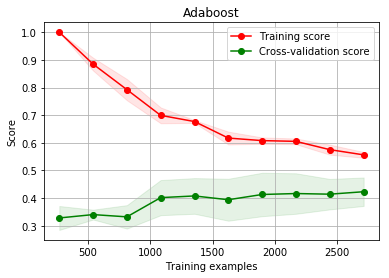

In [151]:
clf_adaboosting_optim = clf_adaboosting.best_estimator_
print(clf_adaboosting_optim)

%matplotlib inline

plot_learning_curve(clf_adaboosting_optim , "Adaboost",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_adaboosting_optim.sav'
pickle.dump(clf_adaboosting_optim, open(filename, 'wb'))

In [84]:
clf_adaboosting_optim = pickle.load(open(r'.\Problem_1_Model\clf_adaboosting_optim.sav','rb'))

start = time()
clf_adaboosting_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of mlp is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_adaboosting_optim.predict(trainset[feature_columns])

y_pred_test = clf_adaboosting_optim.predict(testset[feature_columns])

clf_adaboosting_perf={'classifier':'adaboost',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=clf_adaboosting_perf

The training time of mlp is 0.829s


In [156]:
#adaboosting on SMOTE
start = time()
clf_adaboosting_smote.fit(X_train_smote, np.ravel(y_train_smote))
print("Adaboosting classifier on SMOTE took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_adaboosting_smote.cv_results_,scoring=['roc_auc','f1'])

Adaboosting classifier on SMOTE took 86.04 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.976 (std: 0.031)
Parameters: {'learning_rate': 0.65, 'algorithm': 'SAMME.R', 'n_estimators': 150}

Model with rank: 2
Mean validation roc_auc: 0.975 (std: 0.031)
Parameters: {'learning_rate': 0.45000000000000007, 'algorithm': 'SAMME.R', 'n_estimators': 175}

Model with rank: 3
Mean validation roc_auc: 0.970 (std: 0.030)
Parameters: {'learning_rate': 0.65, 'algorithm': 'SAMME.R', 'n_estimators': 75}

Model with rank: 1
Mean validation f1: 0.900 (std: 0.103)
Parameters: {'learning_rate': 0.65, 'algorithm': 'SAMME.R', 'n_estimators': 150}

Model with rank: 2
Mean validation f1: 0.898 (std: 0.065)
Parameters: {'learning_rate': 0.30000000000000004, 'algorithm': 'SAMME.R', 'n_estimators': 150}

Model with rank: 3
Mean validation f1: 0.897 (std: 0.097)
Parameters: {'learning_rate': 0.45000000000000007, 'algorithm': 'SAMME.R', 'n_estimators': 175}



AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.65, n_estimators=150, random_state=None)


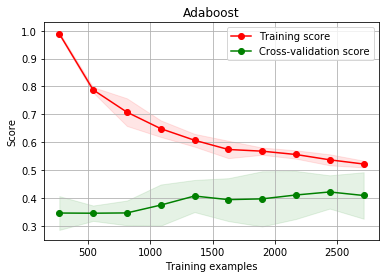

In [157]:
#clf_adaboosting_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_adaboosting_smote_optim.sav', 'rb'))
clf_adaboosting_smote_optim = clf_adaboosting_smote.best_estimator_
print(clf_adaboosting_smote_optim)

%matplotlib inline

plot_learning_curve(clf_adaboosting_smote_optim , "Adaboost",
                    trainset[feature_columns], trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_adaboosting_smote_optim.sav'
pickle.dump(clf_adaboosting_smote_optim, open(filename, 'wb'))

In [48]:
#clf_adaboosting_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_adaboosting_smote_optim.sav','rb'))
start = time()
clf_adaboosting_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of adaboost after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_adaboosting_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_adaboosting_smote_optim.predict(testset[feature_columns])

adaboosting_smote_perf={'classifier':'adaboost_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=adaboosting_smote_perf

The training time of adaboost after SMOTE is 0.537s


In [28]:
#graident boost
start = time()
clf_gradientboosting.fit(trainset[feature_columns],trainset['y_label'])
print("Gradient boost classifier took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_gradientboosting.cv_results_,scoring=['roc_auc','f1'])

Gradient boost classifier took 401.92 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.907 (std: 0.011)
Parameters: {'min_samples_split': 4, 'learning_rate': 0.1, 'loss': 'exponential', 'max_features': 'log2', 'n_estimators': 200, 'criterion': 'friedman_mse', 'max_depth': 9, 'subsample': 0.7000000000000001}

Model with rank: 2
Mean validation roc_auc: 0.905 (std: 0.014)
Parameters: {'min_samples_split': 8, 'learning_rate': 0.25, 'loss': 'exponential', 'max_features': None, 'n_estimators': 175, 'criterion': 'friedman_mse', 'max_depth': 9, 'subsample': 0.9}

Model with rank: 3
Mean validation roc_auc: 0.894 (std: 0.013)
Parameters: {'min_samples_split': 10, 'learning_rate': 0.5, 'loss': 'exponential', 'max_features': 'auto', 'n_estimators': 175, 'criterion': 'friedman_mse', 'max_depth': 7, 'subsample': 0.7000000000000001}

Model with rank: 1
Mean validation f1: 0.485 (std: 0.023)
Parameters: {'min_samples_split': 6, 'learning_rate': 0.65, 'loss'

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.65,
              loss='deviance', max_depth=9, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=6, min_weight_fraction_leaf=0.0,
              n_estimators=50, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)


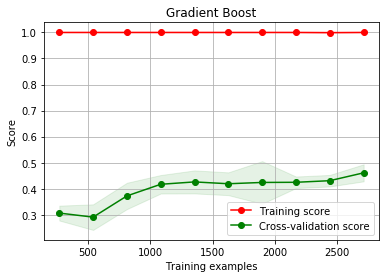

In [29]:
clf_gradientboosting_optim = clf_gradientboosting.best_estimator_
print(clf_gradientboosting_optim)

%matplotlib inline

plot_learning_curve(clf_gradientboosting_optim , "Gradient Boost",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_gradientboosting_optim.sav'
pickle.dump(clf_gradientboosting_optim, open(filename, 'wb'))

In [50]:
#clf_gradientboosting_optim = pickle.load(open(r'.\Problem_1_Model\clf_gradientboosting_optim.sav','rb'))

start = time()
clf_gradientboosting_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of graident boosting is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_gradientboosting_optim.predict(trainset[feature_columns])

y_pred_test = clf_gradientboosting_optim.predict(testset[feature_columns])


gradientboosting_perf={'classifier':'gradientboosting',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=gradientboosting_perf

The training time of graident boosting is 0.609s


In [33]:
#gradient boosting on SMOTE
start = time()
clf_gradientboosting_smote.fit(X_train_smote, y_train_smote)
print("Gradientboosting classifier on SMOTE took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_gradientboosting_smote.cv_results_,scoring=['roc_auc','f1'])

Gradientboosting classifier on SMOTE took 5812.19 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.993 (std: 0.012)
Parameters: {'min_samples_split': 8, 'learning_rate': 0.45000000000000007, 'loss': 'deviance', 'max_features': 'log2', 'n_estimators': 150, 'criterion': 'friedman_mse', 'max_depth': 9, 'subsample': 1.0}

Model with rank: 2
Mean validation roc_auc: 0.993 (std: 0.007)
Parameters: {'min_samples_split': 2, 'learning_rate': 0.2, 'loss': 'deviance', 'max_features': 'log2', 'n_estimators': 250, 'criterion': 'mse', 'max_depth': None, 'subsample': 0.30000000000000004}

Model with rank: 3
Mean validation roc_auc: 0.992 (std: 0.010)
Parameters: {'min_samples_split': 8, 'learning_rate': 0.65, 'loss': 'exponential', 'max_features': 'log2', 'n_estimators': 225, 'criterion': 'friedman_mse', 'max_depth': None, 'subsample': 0.5}

Model with rank: 1
Mean validation f1: 0.944 (std: 0.043)
Parameters: {'min_samples_split': 2, 'learning_rate': 0.2, '

GradientBoostingClassifier(criterion='mse', init=None, learning_rate=0.2,
              loss='deviance', max_depth=None, max_features='log2',
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=250, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=0.30000000000000004, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)


C:\Anaconda\envs\py35\lib\site-packages\sklearn\model_selection\_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\model_selection\_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  FitFailedWarning)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\model_selection\_validation.py:559: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: y contains 1 class after sample_weight trimmed

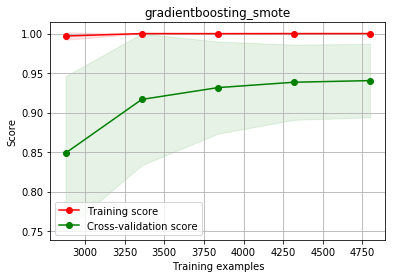

In [34]:
clf_gradientboosting_smote_optim = clf_gradientboosting_smote.best_estimator_
print(clf_gradientboosting_smote_optim)

%matplotlib inline

plot_learning_curve(clf_gradientboosting_smote_optim , "gradientboosting_smote",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_gradientboosting_smote_optim.sav'
pickle.dump(clf_gradientboosting_smote_optim, open(filename, 'wb'))


In [53]:
#clf_gradientboosting_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_gradientboosting_smote_optim.sav','rb'))

start = time()
clf_gradientboosting_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of graident boosting after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_gradientboosting_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_gradientboosting_smote_optim.predict(testset[feature_columns])


gradientboosting_smote_perf={'classifier':'gradientboosting_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=gradientboosting_smote_perf

The training time of graident boosting after SMOTE is 2.955s


In [37]:
#MLP
n_iter_search = 20
parameters = {'hidden_layer_sizes':[(i,) for i in np.linspace(5,50,num=10).astype(int)]+\
              [(i,i) for i in np.linspace(5,50,num=10).astype(int)]+[(i,i,i) for i in np.linspace(5,50,num=10).astype(int)], 
              'activation': ['identity','logistic','tanh','relu'], 'solver':['lbfgs','sgd','adam'],
              'alpha':np.linspace(0.00001,0.0002,num=20),'learning_rate':['constant','invscaling','adaptive'],
              'learning_rate_init':np.linspace(0.00001,0.0002,num=20)}

clf_mlp = clf_mlp_smote = RandomizedSearchCV(MLPClassifier(max_iter=5000), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring=['roc_auc','f1'], cv=5,refit='f1')

In [39]:
start = time()
clf_mlp.fit(trainset[feature_columns],trainset['y_label'])
print("Multi-layer Perceptron classifier took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_mlp.cv_results_,scoring=['roc_auc','f1'])

C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: 

Multi-layer Perceptron classifier took 1537.93 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.869 (std: 0.011)
Parameters: {'solver': 'adam', 'alpha': 0.00018, 'learning_rate': 'constant', 'learning_rate_init': 0.00017, 'hidden_layer_sizes': (20,), 'activation': 'tanh'}

Model with rank: 2
Mean validation roc_auc: 0.864 (std: 0.014)
Parameters: {'solver': 'adam', 'alpha': 2e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'hidden_layer_sizes': (10, 10), 'activation': 'logistic'}

Model with rank: 3
Mean validation roc_auc: 0.862 (std: 0.012)
Parameters: {'solver': 'adam', 'alpha': 0.00015000000000000001, 'learning_rate': 'constant', 'learning_rate_init': 4e-05, 'hidden_layer_sizes': (30, 30), 'activation': 'relu'}

Model with rank: 1
Mean validation f1: 0.394 (std: 0.031)
Parameters: {'solver': 'lbfgs', 'alpha': 7.000000000000001e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 3.0000000000000004e-05, 'hidden_layer_size

MLPClassifier(activation='relu', alpha=7.000000000000001e-05,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(25, 25),
       learning_rate='adaptive', learning_rate_init=3.0000000000000004e-05,
       max_iter=5000, momentum=0.9, n_iter_no_change=10,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


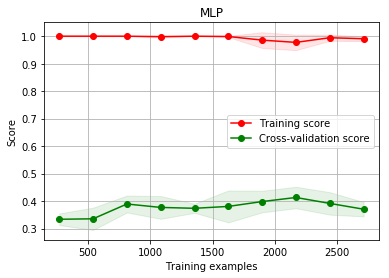

In [40]:
clf_mlp_optim = clf_mlp.best_estimator_
print(clf_mlp_optim)

%matplotlib inline

plot_learning_curve(clf_mlp_optim , "MLP",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',#ylim=(0.6, 1.01),
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_mlp_optim.sav'
pickle.dump(clf_mlp_optim, open(filename, 'wb'))

In [58]:
#clf_mlp_optim = pickle.load(open(r'.\Problem_1_Model\clf_mlp_optim.sav','rb'))

start = time()
clf_mlp_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of mlp is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_mlp_optim.predict(trainset[feature_columns])

y_pred_test = clf_mlp_optim.predict(testset[feature_columns])


mlp_perf={'classifier':'mlp',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=mlp_perf

The training time of mlp is 40.263s


In [54]:
clf_mlp_optim = pickle.load(open(r'.\Problem_1_Model\clf_mlp_optim.sav','rb'))
clf_mlp_optim.n_iter_ 

5001

In [42]:
#mlp on SMOTE
start = time()
clf_mlp_smote.fit(X_train_smote, y_train_smote)
print("Multi-layer Perceptron classifier on SMOTE took %.2f seconds for %d candidates parameter settings." % \
      ((time() - start), n_iter_search))
report(clf_mlp_smote.cv_results_,scoring=['roc_auc','f1'])

Multi-layer Perceptron classifier on SMOTE took 2120.40 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation roc_auc: 0.946 (std: 0.004)
Parameters: {'solver': 'lbfgs', 'alpha': 6e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 2e-05, 'hidden_layer_sizes': (45,), 'activation': 'relu'}

Model with rank: 2
Mean validation roc_auc: 0.939 (std: 0.007)
Parameters: {'solver': 'lbfgs', 'alpha': 5e-05, 'learning_rate': 'constant', 'learning_rate_init': 7.000000000000001e-05, 'hidden_layer_sizes': (35, 35), 'activation': 'logistic'}

Model with rank: 3
Mean validation roc_auc: 0.936 (std: 0.005)
Parameters: {'solver': 'lbfgs', 'alpha': 4e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011, 'hidden_layer_sizes': (25, 25), 'activation': 'tanh'}

Model with rank: 1
Mean validation f1: 0.915 (std: 0.020)
Parameters: {'solver': 'lbfgs', 'alpha': 6e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 2e-05, 'hidden_layer_sizes': (45,), 'activation': 

MLPClassifier(activation='relu', alpha=6e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(45,), learning_rate='adaptive',
       learning_rate_init=2e-05, max_iter=5000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


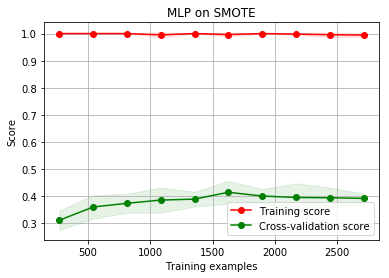

In [43]:
clf_mlp_smote_optim = clf_mlp_smote.best_estimator_
print(clf_mlp_smote_optim)

%matplotlib inline

plot_learning_curve(clf_mlp_smote_optim , "MLP on SMOTE",
                    trainset[feature_columns],trainset['y_label'], scoring='f1',
                    train_sizes=np.array(range(1,11,1))/10)

# save the model to disk
filename = r'.\Problem_1_Model\clf_mlp_smote_optim.sav'
pickle.dump(clf_mlp_smote_optim, open(filename, 'wb'))

In [57]:
#clf_mlp_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_mlp_optim.sav','rb'))

start = time()
clf_mlp_smote_optim.fit(trainset[feature_columns], trainset['y_label'])
print('The training time of mlp after SMOTE is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_mlp_smote_optim.predict(trainset[feature_columns])

y_pred_test = clf_mlp_smote_optim.predict(testset[feature_columns])

mlp_smote_perf={'classifier':'mlp_smote',
           'trainset_roc_auc':roc_auc_score(trainset['y_label'],y_pred_train),
           'testset_roc_auc':roc_auc_score(testset['y_label'],y_pred_test),
           'trainset_f1':f1_score(trainset['y_label'],y_pred_train),
           'testset_f1':f1_score(testset['y_label'],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=mlp_smote_perf

The training time of mlp after SMOTE is 30.167s


In [55]:
clf_mlp_smote_optim = pickle.load(open(r'.\Problem_1_Model\clf_mlp_smote_optim.sav','rb'))
clf_mlp_smote_optim.n_iter_ 

35

In [114]:
clf_performance.to_csv('model_performance_p1.csv')